In [ ]:
#ISSUE
#Cleanup of Code
# Fix def feature_generator_val(files): to refer to cataract4


#Need to try different architectures, base models and different pre-processing
    # mRGB CNN
    # RGBHires FCN

In [1]:
from tqdm import tqdm
import numpy as np
import csv
import os
from PIL import Image
import matplotlib.pyplot as plt
from glob import glob
from keras.models import Model
from keras.layers import Input, merge, Conv2D, MaxPooling2D, UpSampling2D, GlobalMaxPooling2D
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras import backend as K
from random import uniform
import bcolz
from time import *
from keras.layers import merge
from keras.layers.core import Lambda
from keras.models import Model
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dropout
from keras.layers import Input, Dense
import math
import pandas as pd
from keras.utils import np_utils as u
import utils; reload(utils)
from utils import *
import resnet50; reload(resnet50)
from resnet50 import Resnet50
from keras.preprocessing.image import ImageDataGenerator
import myFunctionsv3; reload(myFunctionsv3)
from myFunctionsv3 import *
from  keras.applications.resnet50 import ResNet50

import gc

%matplotlib inline
%cd '/cataract/home/ubuntu/cataract/02_code'

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)


/cataract/home/ubuntu/cataract/02_code


Create a base model using Resnet and initialize with imagenet weights. Add a lambda layer at the beginning to normalize and remove the fully connected layers at the end

In [2]:
imagenet_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape(1,1,3)
def resnet_preprocess(x):
    """
        Subtracts the mean RGB value, and transposes RGB to BGR.
        The mean RGB was computed on the image set used to train the RESNET model.

        Args: 
            x: Image array (height x width x channels)
        Returns:
            Image array (height x width x transposed_channels)
    """
    x = x - imagenet_mean
    x = x[...,[2,1,0]] # reverse axis rgb->bgr
    return x  

In [3]:
model = Sequential()
model.add(Lambda(resnet_preprocess, input_shape=(360,640,3), output_shape=(360,640,3)))
resnet50 = ResNet50(include_top=False, weights='imagenet', input_shape=(360,640,3))
model.add(Model(inputs=resnet50.input, outputs=resnet50.layers[-34].output))
model.compile(SGD(0.05), 'binary_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 360, 640, 3)       0         
_________________________________________________________________
model_1 (Model)              (None, 23, 40, 1024)      8589184   
Total params: 8,589,184
Trainable params: 8,558,592
Non-trainable params: 30,592
_________________________________________________________________


Precompute the features and save to disk to save training time

In [4]:
def createFeatures(path,name):
    rgb_hires = load_array(path + name + '_rgb_hires.dat')
    rgb_hires = np.transpose(rgb_hires,(0,2,3,1))
    conv_feat = model.predict(rgb_hires, batch_size=32, verbose=0)
    save_array('/cataract3/home/ubuntu/cataract3/03_output/'+name+'_fcf_feat.dat',conv_feat)
    del(conv_feat,rgb_hires)
    gc.collect()

In [ ]:
createFeatures('../03_output/','train01')

In [ ]:
files = ['train02','train03','train04','train05','train06','train07','train08','train09','train10','train11',
         'train12','train13','train14','train15','train16','train17','train18','train19','train20','train21','train22',
         'train23','train24','train25'] 

for i in tqdm(range(len(files))):
    createFeatures('../03_output/',files[i])

Sampling Strategy:

    Total Frames - 82479
        
    All frames with 1 2 or 3 and no 0.5 in any of the 21 labels - included (30393+ 13816 + 34 = 44243 or 53.6%)
    
    Frames with 0 across previous 3 seconds and post 3 seconds - included (20996 or 25.4%) 
    
    Others - excluded (17240 or 19.6%)
    

Cross Validation strategy, 

     Train 22 - Train 25
     
     Use all frames

In [5]:
files = ['train01','train02','train03','train04','train05','train06','train07','train08','train09','train10','train11',
         'train12','train13','train14','train15','train16','train17','train18','train19','train20','train21','train22',
         'train23','train24','train25'] 

labels = load_array('../03_output/train01_labels.dat')
for i in tqdm(range(1,len(files))):
    lbl = load_array('../03_output/'+files[i]+'_labels.dat')
    labels = np.vstack((labels,lbl))
    del(lbl)
    gc.collect()
labels[labels==0.5]=999
anyLabel = sum(np.transpose(labels)[3:23,:])
from scipy.ndimage.interpolation import shift

lagggedLabels = shift(anyLabel, -15, cval=1)
lagggedLabels[lagggedLabels<0.5]=0
for i in range(30):
    temp = shift(anyLabel, -14+i, cval=1)
    temp[temp<0.5]=0
    lagggedLabels = np.vstack((lagggedLabels,temp))

anyLabelLag15 = sum(lagggedLabels)
anyLabelLag15[anyLabelLag15>0]=1
keepOrNot = np.vstack((anyLabel,anyLabelLag15)).T
unique, counts = np.unique(keepOrNot[:,0], return_counts=True)
unique, counts

100%|██████████| 24/24 [00:03<00:00,  7.17it/s]


(array([  0.0000e+00,   1.0000e+00,   2.0000e+00,   3.0000e+00,   9.9900e+02,   1.0000e+03,
          1.0010e+03,   1.9980e+03,   1.9990e+03,   2.9970e+03]),
 array([36061, 30393, 13816,    34,  1595,   315,    27,   198,    22,    19]))

In [6]:
unique, counts = np.unique(keepOrNot[:,1], return_counts=True)
unique, counts

(array([ 0.,  1.]), array([20997, 61483]))

Remove unwanted frames from training dataset 

In [7]:
keepOrNot.shape

(82480, 2)

In [8]:
#QC
videos = glob('../01_input/train/*.mp4')
path='../01_input/train/'
totalFrames = 0
totalFrames_Array = 0
for i in range(len(videos)):
    name = videos[i].split("../01_input/train/")[1].split('.mp4')[0]
    labels = pd.read_csv(path + name + '.csv').values
    labels_array = load_array('../03_output/'+name+'_labels.dat')
    print name, labels.shape[0] , labels_array.shape[0]
    totalFrames += labels.shape[0]
    totalFrames_Array += labels_array.shape[0]
print totalFrames,totalFrames/6, totalFrames_Array

train01 14380 2397
train17 12433 2072
train19 71066 11843
train12 21574 3595
train08 27463 4577
train05 12778 2130
train10 25569 4262
train06 13848 2308
train13 14021 2337
train18 13952 2325
train21 15463 2578
train25 40820 6802
train16 18232 3039
train20 16939 2824
train22 20664 3445
train09 15973 2662
train11 14252 2376
train23 11182 1864
train03 17490 2915
train24 18591 3099
train14 20544 3424
train15 13762 2294
train04 13266 2211
train07 18769 3128
train02 11837 1973
494868 82478 82480


In [ ]:
files = ['train01','train02','train03','train04','train05','train06','train07','train08','train09','train10',
         'train11','train12','train13','train14','train15','train16','train17','train18']

keepFileindex=0

for i in tqdm(range(len(files))):
    lbl = load_array('../03_output/'+files[i]+'_labels.dat')
    feats = load_array('/cataract3/home/ubuntu/cataract3/03_output/'+files[i]+'_fcf_feat.dat')
    rgb_hires = load_array('/cataract/home/ubuntu/cataract/03_output/'+files[i]+'_rgb_hires.dat')

    FIRST_TIME = True
    feats_new = np.zeros([lbl.shape[0],23,40,1024],dtype=np.float32)
    rgb_hires_new = np.zeros([lbl.shape[0],3,360,640],dtype=np.float32)

    arrayIndex = 0
    for j in range(lbl.shape[0]):
        if(keepOrNot[keepFileindex,0]<4):
            if((keepOrNot[keepFileindex,1]==0 and keepOrNot[keepFileindex,0]==0) or keepOrNot[keepFileindex,0]>0):
                if FIRST_TIME:
                    lbl_new = lbl[j]
                    FIRST_TIME = False
                else:
                    lbl_new = np.vstack((lbl_new,lbl[j]))
                feats_new[arrayIndex] = feats[j]
                rgb_hires_new[arrayIndex] = rgb_hires[j]
                arrayIndex += 1
        keepFileindex += 1

    feats_final = np.zeros([arrayIndex,23,40,1024],dtype=np.float32)
    feats_final[0:arrayIndex] = feats_new[0:arrayIndex]
    rgb_hires_final = np.zeros([arrayIndex,3,360,640],dtype=np.uint8)
    rgb_hires_final[0:arrayIndex] = rgb_hires_new[0:arrayIndex]

    save_array('/cataract3/home/ubuntu/cataract3/03_output/'+files[i]+'_labels.dat',lbl_new)
    save_array('/cataract3/home/ubuntu/cataract3/03_output/'+files[i]+'_fcf_feat.dat',feats_final)
    #save_array('/cataract2/home/ubuntu/cataract2/03_output/'+files[i]+'_rgb_hires_temp.dat',rgb_hires_final)

    del(lbl,feats,lbl_new,feats_new,feats_final,rgb_hires,rgb_hires_new)
    gc.collect()

In [ ]:
files = ['train01','train02','train03','train04','train05','train06','train07','train08','train09','train10',
        'train11','train12','train13','train14','train15','train16','train17','train18']
keepFileindex=0
for i in tqdm(range(len(files))):
    lbl = load_array('../03_output/'+files[i]+'_labels.dat')
    for j in range(lbl.shape[0]):
        keepFileindex += 1
print keepFileindex

Run this part in a 124GB RAM Machine

In [ ]:
files = ['train19','train20']

keepFileindex=50025

for i in tqdm(range(len(files))):
    lbl = load_array('../03_output/'+files[i]+'_labels.dat')
    feats = load_array('/cataract3/home/ubuntu/cataract3/03_output/'+files[i]+'_fcf_feat.dat')

    FIRST_TIME = True
    feats_new = np.zeros([lbl.shape[0],23,40,1024],dtype=np.float32)

    arrayIndex = 0
    for j in range(lbl.shape[0]):
        if(keepOrNot[keepFileindex,0]<4):
            if((keepOrNot[keepFileindex,1]==0 and keepOrNot[keepFileindex,0]==0) or keepOrNot[keepFileindex,0]>0):
                if FIRST_TIME:
                    lbl_new = lbl[j]
                    FIRST_TIME = False
                else:
                    lbl_new = np.vstack((lbl_new,lbl[j]))
                feats_new[arrayIndex] = feats[j]
                arrayIndex += 1
        keepFileindex += 1

    feats_final = np.zeros([arrayIndex,23,40,1024],dtype=np.float32)
    feats_final[0:arrayIndex] = feats_new[0:arrayIndex]

    save_array('/cataract3/home/ubuntu/cataract3/03_output/'+files[i]+'_labels.dat',lbl_new)
    save_array('/cataract3/home/ubuntu/cataract3/03_output/'+files[i]+'_fcf_feat.dat',feats_final)

    del(lbl,feats,lbl_new,feats_new,feats_final)
    gc.collect()

Break train19 and train25 into 3 parts to fit into memory

In [ ]:
lbl = load_array('/cataract3/home/ubuntu/cataract3/03_output/train19_labels.dat')
feats = load_array('/cataract3/home/ubuntu/cataract3/03_output/train19_fcf_feat.dat')
count=feats.shape[0]
count

In [ ]:
save_array('/cataract3/home/ubuntu/cataract3/03_output/train19A_labels.dat',lbl[0:3000])
save_array('/cataract3/home/ubuntu/cataract3/03_output/train19A_fcf_feat.dat',feats[0:3000])
save_array('/cataract3/home/ubuntu/cataract3/03_output/train19B_labels.dat',lbl[3000:6000])
save_array('/cataract3/home/ubuntu/cataract3/03_output/train19B_fcf_feat.dat',feats[3000:6000])
save_array('/cataract3/home/ubuntu/cataract3/03_output/train19C_labels.dat',lbl[6000:count])
save_array('/cataract3/home/ubuntu/cataract3/03_output/train19C_fcf_feat.dat',feats[6000:count])
del(lbl,feats)
gc.collect()

In [ ]:
lbl = load_array('/cataract/home/ubuntu/cataract/03_output/train25_labels.dat')
feats = load_array('/cataract4/home/ubuntu/cataract4/03_output/train25_fcf_feat.dat')
count=feats.shape[0]
count

In [ ]:
save_array('/cataract/home/ubuntu/cataract/03_output/train25A_labels.dat',lbl[0:3000])
save_array('/cataract4/home/ubuntu/cataract4/03_output/train25A_fcf_feat.dat',feats[0:3000])
save_array('/cataract/home/ubuntu/cataract/03_output/train25B_labels.dat',lbl[3000:count])
save_array('/cataract4/home/ubuntu/cataract4/03_output/train25B_fcf_feat.dat',feats[3000:count])
del(lbl,feats)
gc.collect()

# Training

In [9]:
nf=384; p=0.01
def get_lrg_layers():
    return [
        BatchNormalization(axis=1, input_shape=(23, 40, 1024)),
        MaxPooling2D(),
        Conv2D(nf,(1,1), activation='relu', padding='same'),
        BatchNormalization(axis=1),
        Conv2D(nf,(3,3), activation='relu', padding='same'),
        BatchNormalization(axis=1),
        Conv2D(nf,(3,3), activation='relu', padding='same'),
        BatchNormalization(axis=1),
        MaxPooling2D(),
        Conv2D(nf,(1,1), activation='relu', padding='same'),
        BatchNormalization(axis=1),
        Conv2D(nf,(3,3), activation='relu', padding='same'),
        BatchNormalization(axis=1),
        Conv2D(nf,(3,3), activation='relu', padding='same'),
        BatchNormalization(axis=1),
        MaxPooling2D(),
        Conv2D(nf,(1,1), activation='relu', padding='same'),
        BatchNormalization(axis=1),
        Conv2D(nf,(3,3), activation='relu', padding='same'),
        BatchNormalization(axis=1),
        Conv2D(21,(3,3), activation='relu', padding='same'),
        BatchNormalization(axis=1),
        GlobalMaxPooling2D(),
        Activation('sigmoid')
    ]

In [10]:
lrg_model = Sequential(get_lrg_layers())

In [11]:
lrg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 23, 40, 1024)      92        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 20, 1024)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 20, 384)       393600    
_________________________________________________________________
batch_normalization_2 (Batch (None, 11, 20, 384)       44        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 20, 384)       1327488   
_________________________________________________________________
batch_normalization_3 (Batch (None, 11, 20, 384)       44        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 20, 384)       1327488   
__________

In [12]:
gc.collect()

27305

In [13]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [14]:
def feature_generator(files):
    while 1:
        for i in range(len(files)):
            conv_trn_feat = load_array('/cataract3/home/ubuntu/cataract3/03_output/'+files[i]+'_fcf_feat.dat')
            label = load_array('/cataract3/home/ubuntu/cataract3/03_output/'+files[i]+'_labels.dat')
            conv_trn_feat, label = unison_shuffled_copies(conv_trn_feat,label)
            totalFrames = label.shape[0]
            batches = int(totalFrames/batch_size)
            for j in range(batches):
                x = conv_trn_feat[j*batch_size:(j+1)*batch_size,]
                y = label[j*batch_size:(j+1)*batch_size,2:23]
                yield (x, y)
            del(conv_trn_feat,label)
            gc.collect()

In [15]:
def feature_generator_val(files):
    while 1:
        for i in range(len(files)):
            conv_val_feat = load_array('/cataract4/home/ubuntu/cataract4/03_output/'+files[i]+'_fcf_feat.dat')
            label_val = load_array('/cataract/home/ubuntu/cataract/03_output/'+files[i]+'_labels.dat')
            totalFrames = label_val.shape[0]
            batches = int(totalFrames/batch_size)
            for j in range(batches): 
                x = conv_val_feat[j*batch_size:(j+1)*batch_size,]
                y = label_val[j*batch_size:(j+1)*batch_size,2:23]
                yield (x, y)
            del(conv_val_feat,label_val)
            gc.collect()

In [16]:
files = ['train01','train02','train03','train04','train05','train06','train07','train08','train09','train10','train11',
         'train12','train13','train14','train15','train16','train17','train18','train19A','train19B','train19C','train20']
totalCount=0
for i in range(len(files)):
    labelFile = load_array('/cataract3/home/ubuntu/cataract3/03_output/'+files[i]+'_labels.dat')
    totalCount += labelFile.shape[0]
    del(labelFile)
print(totalCount)

51497


In [17]:
files_val = ['train21','train22','train23','train24','train25A','train25B']
totalCountVal=0
for i in range(len(files_val)):
    labelFile = load_array('/cataract/home/ubuntu/cataract/03_output/'+files_val[i]+'_labels.dat')
    totalCountVal += labelFile.shape[0]
    del(labelFile)
print(totalCountVal)

17788


In [18]:
lrg_model.compile(SGD(lr=0.05,momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])
batch_size=32

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', patience=4, verbose=1,min_delta=1e-4),
             ReduceLROnPlateau(monitor='val_loss',factor=0.1, patience=2, cooldown=2, verbose=1),
                 ModelCheckpoint(filepath='best_weights.hdf5',save_best_only=True,save_weights_only=True)]

In [ ]:
history = lrg_model.fit_generator(feature_generator(files),steps_per_epoch=totalCount/batch_size,
                                  nb_epoch=50,callbacks=callbacks,
                                  validation_data=feature_generator_val(files_val),validation_steps=totalCountVal/batch_size) 

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  app.launch_new_instance()
/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_data=<generator..., steps_per_epoch=1609, epochs=50, callbacks=[<keras.ca..., validation_steps=555)`
  app.launch_new_instance()


Epoch 1/50
1609/1609 [==============================] - 4187s - loss: 0.0914 - acc: 0.9711 - val_loss: 0.1195 - val_acc: 0.9698
Epoch 2/50
1609/1609 [==============================] - 4074s - loss: 0.0635 - acc: 0.9809 - val_loss: 0.1067 - val_acc: 0.9747
Epoch 3/50
1609/1609 [==============================] - 4023s - loss: 0.0359 - acc: 0.9888 - val_loss: 0.0755 - val_acc: 0.9796
Epoch 4/50
1609/1609 [==============================] - 3874s - loss: 0.0220 - acc: 0.9930 - val_loss: 0.0692 - val_acc: 0.9820
Epoch 5/50
1609/1609 [==============================] - 4149s - loss: 0.0141 - acc: 0.9957 - val_loss: 0.0641 - val_acc: 0.9821
Epoch 6/50
1609/1609 [==============================] - 4099s - loss: 0.0087 - acc: 0.9974 - val_loss: 0.0620 - val_acc: 0.9830
Epoch 7/50
1609/1609 [==============================] - 4229s - loss: 0.0062 - acc: 0.9982 - val_loss: 0.0654 - val_acc: 0.9828
Epoch 8/50
1609/1609 [==============================] - 3989s - loss: 0.0045 - acc: 0.9987 - val_loss: 0

Training Curves

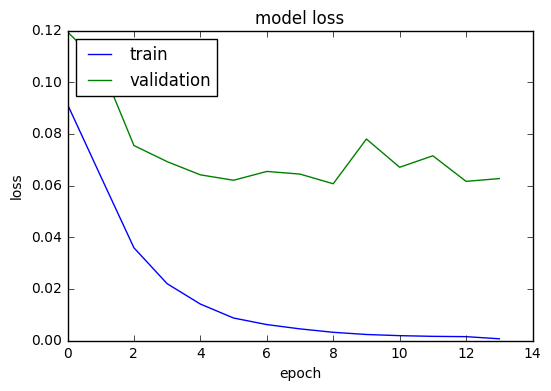

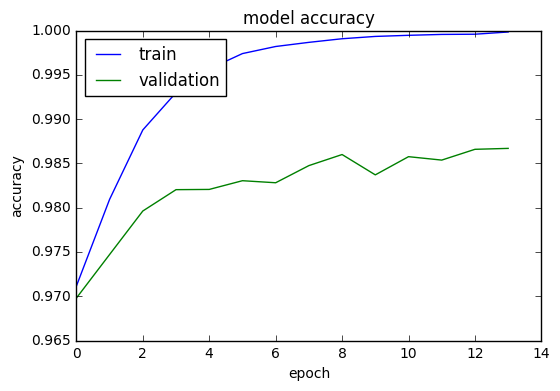

In [21]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [22]:
lrg_model.save_weights('/cataract2/home/ubuntu/cataract2/03_output/resnet_256_sigmoid_3layer_conv.hdf5')

# Evaluate

In [61]:
files=['train21','train22','train23','train24','train25']
i=0
conv_val_feat = load_array('/cataract4/home/ubuntu/cataract4/03_output/'+files[i]+'_fcf_feat.dat')
labels_val = load_array('/cataract/home/ubuntu/cataract/03_output/'+files[i]+'_labels.dat')

In [58]:
conv_val_feat.shape , labels_val.shape

((1864, 23, 40, 1024), (1864, 23))

In [48]:
lrg_model.load_weights('/cataract/home/ubuntu/cataract/02_code/best_weights.hdf5')

In [49]:
frame=155
np.round(lrg_model.predict(np.expand_dims(conv_val_feat[frame], 0))[0],2)

array([ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.34,  0.  ,  0.  ,  0.  ,  0.  ], dtype=float32)

In [50]:
labels_val[frame,2:23]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.])

In [64]:
files=['train21','train22','train23','train24','train25']
FIRST_TIME=True
for i in range(len(files)):
    conv_val_feat = load_array('/cataract4/home/ubuntu/cataract4/03_output/'+files[i]+'_fcf_feat.dat')
    labels_val = load_array('/cataract/home/ubuntu/cataract/03_output/'+files[i]+'_labels.dat')
    if FIRST_TIME:
        predictions_all = lrg_model.predict(conv_val_feat)    
        labels_all = labels_val
        FIRST_TIME = False
    else:
        predictions_all = np.vstack((predictions_all,lrg_model.predict(conv_val_feat)))
        labels_all = np.vstack((labels_all,labels_val))
    del(conv_val_feat,labels_val)
    gc.collect()
print predictions_all.shape, labels_all.shape

(17788, 21) (17788, 23)


In [65]:
# Computing the area under the ROC curve
from sklearn.metrics import roc_curve, auc
from math import isnan

totalScore=0
count = 0

predictions_temp = np.copy(predictions_all)
truth_temp = np.copy(labels_all)

for j in range(21):   
    index = 0
    #remove rows with label = 0.5
    for i in range(labels_all.shape[0]):
        if labels_all[i,j+2] != 0.5:
            truth_temp[index,j+2]=labels_all[i,j+2]
            predictions_temp[index,j]=predictions_all[i,j]
            index += 1
    fpr, tpr, _ = roc_curve(truth_temp[0:index,j+2], predictions_temp[0:index,j])
    score = auc(fpr, tpr)
    print j, score
    if isnan(score):
        score=0.0
    else:
        totalScore+=score
        count +=1
    
print totalScore/count

0 0.650635001032
1 0.928904228011
2 0.978613541668
3 0.914522185858
4 0.929902889882
5 0.852312891277
6 0.996741505124
7 0.955605991235
8 0.949656018782
9 nan
10 0.962325939223
11 0.992618766702
12 0.995134433465
13 nan
14 0.98487124927
15 0.98770098815
16 0.985812857601
17 0.984382601194
18 0.828882690149
19 0.306138669266
20 nan
0.899153469327



  train21 ; 0.957 

  train22 ; 0.972

  train23 ; 0.993

  train24 ; 0.924

  train25 ; 0.865

train21-5 ; 0.899


In [60]:
del(conv_val_feat)
gc.collect()

0

# Visualize

In [ ]:
rgb_hires = load_array('/cataract2/home/ubuntu/cataract2/03_output/train21_rgb_hires_temp.dat')
rgb_hires.shape

In [ ]:
labels = load_array('/cataract2/home/ubuntu/cataract2/03_output/train21_labels_temp.dat')
labels[2000,...]

In [ ]:
conv_trn_feat = load_array('/cataract2/home/ubuntu/cataract2/03_output/train21_fcf_feat_temp.dat')
labels.shape,conv_trn_feat.shape,rgb_hires.shape

In [ ]:
#load weights
l = lrg_model.layers
conv_fn = K.function([l[0].input, K.learning_phase()], l[-5].output)

In [ ]:
def get_cm2(inp, label):
    conv = conv_fn([inp,0])[0, label]
    return scipy.misc.imresize(conv, (360,640))

In [ ]:
def plotImages(frame):
    from matplotlib.colors import LinearSegmentedColormap
    colors = ['red', 'brown', 'yellow', 'green', 'blue']
    cmap = LinearSegmentedColormap.from_list('name', colors)
    norm = plt.Normalize(0, 254)
    inp = np.expand_dims(conv_trn_feat[frame], 0)
    index_array = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
    f = plt.figure(figsize=(10, 40))
    r = len(index_array)

    A = np.transpose(rgb_hires,(0,2,3,1))[frame,]

    for k, i in enumerate(index_array):
        for j , M in enumerate([A,A,A]):
            sp = f.add_subplot(r, 3, 3*k + j + 1)
            sp.axis('Off')
            if j==0:
                plt.imshow(M)
            else:
                if j==1:
                    plt.imshow(get_cm2(inp, i), cmap='cool', norm=norm, interpolation='none') 
                else:
                    plt.imshow(M)
                    plt.imshow(get_cm2(inp, i), cmap='cool', norm=norm, interpolation='none', alpha=0.5) 

256 convolutions filters

In [ ]:
plotImages(2000)

In [ ]:
plotImages(1000)

In [ ]:
#plotImages(2000)

In [ ]:
#plotImages(3500)

In [ ]:
#plotImages(1500)

In [ ]:
labels[600,2:23]

In [ ]:
#plotImages(600)

128 convolution filters

In [ ]:
plotImages(100)

In [ ]:
plt.imshow(np.transpose(rgb_hires,(0,2,3,1))[1000,])

In [ ]:
cm = get_cm2(inp, 0)

In [ ]:
plt.imshow(cm, cmap="hot") # binary cross entropy with softmax

In [ ]:
gc.collect()

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(rgb_hires,(0,2,3,1))[1000,])
plt.imshow(cm, cmap="hot", alpha=0.5) 

In [ ]:
cm = get_cm2(inp, 7)
plt.imshow(cm, cmap="gray") # binary cross entropy with softmax

In [ ]:
lr = [0.01,0.001,0.0001,0.00001]
e =[1,2,2,2]
p = [0.6]
tuneMyNw('fold_4','03_output/features',lr,e,p,get_lrg_layers,batch_size,allTags=True,base_model=None,early_stop=1)

In [ ]:
features, labels = loadFeatures('03_output/features','fold_4')
predictFolds('fold_4',get_bn_layers,'vgg',features,allTags=True,base_model='vgg')
np.savetxt('03_output/results/labels_vgg_fold_4.csv', labels, delimiter=",")

In [ ]:

tags = ['all']

learningSchedules = {}
learningSchedules['1'] = [0.01,0.001,0.0001]
learningSchedules['2'] = [0.01,0.001]
learningSchedules['3'] = [0.01]

epochSchedules = {}
epochSchedules['1'] = [1,2,4]
epochSchedules['2'] = [1,2]
epochSchedules['3'] = [1,2,3]
epochSchedules['4'] = [1,2,5]
epochSchedules['5'] = [1]
epochSchedules['6'] = [1,2,1]

dropouts = [0.8]
learningSchedule = ['1']
epochSchedule = ['1']

features, labels = loadFeatures('03_output/features','train')
trainFolds('test',tags,dropouts,learningSchedule,learningSchedules,epochSchedule,epochSchedules,
           get_bn_layers,'vgg',features, labels,batch_size,allTags=True,base_model='vgg')


In [ ]:
features, labels = loadFeatures('03_output/testfeatures', 'test')
predictFolds('test',get_bn_layers,'vgg',features,allTags=True,base_model='vgg')
np.savetxt('03_output/results/labels_vgg_test.csv', labels, delimiter=",")

# Scrapbook

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io,transform
%matplotlib inline

def data_aug(img = img):
	mu = 0
	sigma = 0.1
	feature_vec=np.matrix(evecs_mat)

	# 3 x 1 scaled eigenvalue matrix
	se = np.zeros((3,1))
	se[0][0] = np.random.normal(mu, sigma)*evals[0]
	se[1][0] = np.random.normal(mu, sigma)*evals[1]
	se[2][0] = np.random.normal(mu, sigma)*evals[2]
	se = np.matrix(se)
	val = feature_vec*se

	# Parse through every pixel value.
	for i in xrange(img.shape[0]):
		for j in xrange(img.shape[1]):
			# Parse through every dimension.
			for k in xrange(img.shape[2]):
				img[i,j,k] = float(img[i,j,k]) + float(val[k])

imnames = ['n00.jpg','n01.jpg','n02.jpg','n03.jpg','n04.jpg','n05.jpg']
#load list of images
imlist = (io.imread_collection(imnames))

res = np.zeros(shape=(1,3))
for i in range(len(imlist)):
	# re-size all images to 256 x 256 x 3
	m=transform.resize(imlist[i],(256,256,3))
	# re-shape to make list of RGB vectors.
	arr=m.reshape((256*256),3)
	# consolidate RGB vectors of all images
	res = np.concatenate((res,arr),axis=0)
res = np.delete(res, (0), axis=0)

# subtracting the mean from each dimension
m = res.mean(axis = 0)
res = res - m

R = np.cov(res, rowvar=False)
print R

from numpy import linalg as LA
evals, evecs = LA.eigh(R)

idx = np.argsort(evals)[::-1]
evecs = evecs[:,idx]
# sort eigenvectors according to same index

evals = evals[idx]
# select the first 3 eigenvectors (3 is desired dimension
# of rescaled data array)

evecs = evecs[:, :3]
# carry out the transformation on the data using eigenvectors
# and return the re-scaled data, eigenvalues, and eigenvectors
m = np.dot(evecs.T, res.T).T

# perturbing color in image[0]
# re-scaling from 0-1
img = imlist[0]/255.0
data_aug(img)
plt.imshow(img)

In [ ]:
labelFile = load_array('/cataract/home/ubuntu/cataract/03_output/train01_labels.dat')
features = load_array('/cataract2/home/ubuntu/cataract2/03_output/train01_fcf_feat.dat')

In [ ]:
lrg_model.fit(conv_trn_feat, labels[:,2:23], batch_size=batch_size, nb_epoch=2, 
             validation_data=(conv_val_feat, labels_val[:,2:23])) #binary cross entropy with sigmoid n = 256

In [ ]:
def auc_tool(truth_directory, prediction_directory, tool):
    """Computes the area under the ROC curve for one tool.
    """
    filename = ''
    try:
    truth = []
    predictions = []
    # loop on (truth, predictions) file pairs
    for file in range(1, num_files + 1):

    # getting the filenames
    if (file < 10):
    filename = file_prefix + '0{}.csv'.format(file)
    else:
    filename = file_prefix + '{}.csv'.format(file)
    truth_filename = join(truth_directory, filename)
    prediction_filename = join(prediction_directory, filename)
    # parsing the right column for the current tool
    truth_data = read_csv(truth_filename, header = 0, skipinitialspace = True,
    usecols = [tool], squeeze = True, dtype = 'float32').tolist()
    prediction_data = read_csv(prediction_filename, header = None, skipinitialspace = True,
    usecols = [tool], squeeze = True, dtype = 'float32').tolist()
    if len(truth_data) != len(prediction_data):
    raise ValueError('Files {} and {} have different row counts'.
    format(truth_filename, prediction_filename))

    # appending rows with consensual ground truth
    indices = [index for index, value in enumerate(truth_data) if value != 0.5]
    truth += [truth_data[index] for index in indices]
    predictions += [prediction_data[index] for index in indices]

    # computing the area under the ROC curve
    fpr, tpr, _ = roc_curve(truth, predictions)
    score = auc(fpr, tpr)
    return 0. if isnan(score) else score
    except Exception as e:
    print('Error: missing column in {} for tool number {}!'.format(filename, tool)
    if 'Usecols' in str(e) else 'Error: {}!'.format(e))
    return 0.


    def main():
    """Main function.
    """

    # parsing the command line
    parser = ArgumentParser(description = 'Evaluator for the CATARACTS challenge.')
    parser.add_argument('-t', '--truth', required = True, help = 'directory containing ground truth files')
    parser.add_argument('-p', '--predictions', required = True, help = 'directory containing automatic predictions')
    args = parser.parse_args()

    # computing tool-specific scores
    scores = []
    for tool in range(1, num_tools + 1):
    score = auc_tool(args.truth, args.predictions, tool)
    print('Score tool {0}: {1:.4f}'.format(tool, score))
    scores.append(score)

    # computing the average score
    print('Average: {0:.4f}'.format(sum(scores) / float(len(scores))))


In [ ]:
path='../03_output/'
name='train01'
rgb_hires = load_array(path + name + '_rgb_hires.dat')

In [ ]:
rgb_hires.shape

In [ ]:
conv_feat = vgg640.predict(rgb_hires[1:100], batch_size=32, verbose=1)

In [ ]:
rgb_hires = load_array('03_output/train01_rgb_hires.dat')
labels = load_array('03_output/train01_labels.dat')

In [ ]:
rgb_hires_val = load_array('03_output/train25_rgb_hires.dat')
labels_val = load_array('03_output/train25_labels.dat')

In [ ]:
rgb_hires_val.shape

In [ ]:
rgb_hires = np.reshape(np.transpose(rgb_hires,(1,0)),(2460,360,640,3)) 

In [ ]:
rgb_hires_val = np.reshape(np.transpose(rgb_hires_val,(1,0)),(6990,360,640,3)) 

In [ ]:
rgb_hires.shape, labels.shape,rgb_hires_val.shape, labels_val.shape

In [ ]:
rgb_hires = np.transpose(rgb_hires,(0,3,1,2)) 
rgb_hires_val = np.transpose(rgb_hires_val,(0,3,1,2))

In [ ]:
labels = np.transpose(labels,(1,0))
labels_val = np.transpose(labels_val,(1,0))

In [ ]:
labels.shape

In [ ]:
rgb_hires.shape
plt.imshow(rgb_hires[0])

In [ ]:
conv_trn_feat = vgg640.predict(rgb_hires_val, batch_size=32, verbose=1)
conv_val_feat = vgg640.predict(rgb_hires, batch_size=32, verbose=1)

In [ ]:
save_array('03_output/train25_fcn_feat.dat',conv_trn_feat)
save_array('03_output/train01_fcn_feat.dat',conv_val_feat)

In [ ]:
conv_layers,_ = split_at(vgg640, Convolution2D)

In [ ]:
nf=128; p=0.0

In [ ]:
nf=256; p=0.2

In [ ]:
nf=256; p=0.2
def get_lrg_layers():
    return [
        BatchNormalization(axis=1, input_shape=conv_layers[-1].output_shape[1:]),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        Convolution2D(21,3,3, border_mode='same'),
        GlobalAveragePooling2D(),
        Activation('softmax')
    ]

In [ ]:
def get_lrg_layers():
    return [
        BatchNormalization(axis=1, input_shape=conv_layers[-1].output_shape[1:]),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        Convolution2D(21,3,3, border_mode='same'),
        GlobalAveragePooling2D(),
        Activation('sigmoid')
    ]

In [ ]:
lrg_model = Sequential(get_lrg_layers())

In [ ]:
lrg_model.summary()

In [ ]:
lrg_model.compile(Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
batch_size = 64

In [ ]:
lrg_model.fit(conv_trn_feat, labels_val[:,1:22], batch_size=batch_size, nb_epoch=2, 
             validation_data=(conv_val_feat, labels[:,1:22])) #binary cross entropy with sigmoid n = 256

In [ ]:
lrg_model.fit(conv_trn_feat, labels_val[:,1:22], batch_size=batch_size, nb_epoch=2, 
             validation_data=(conv_val_feat, labels[:,1:22])) #binary cross entropy with softmax n = 128

In [ ]:
lrg_model.fit(conv_trn_feat, labels_val[:,1:22], batch_size=batch_size, nb_epoch=2, 
             validation_data=(conv_val_feat, labels[:,1:22])) #binary cross entropy with sigmoid n = 128

In [ ]:
lrg_model.optimizer.lr=1e-5

In [ ]:
lrg_model.fit(conv_trn_feat, labels_val[:,1:22], batch_size=batch_size, nb_epoch=4, 
             validation_data=(conv_val_feat, labels[:,1:22])) #categorical cross entropy with softmax n = 128

In [ ]:
lrg_model.fit(conv_trn_feat, labels_val[:,1:22], batch_size=batch_size, nb_epoch=4, 
             validation_data=(conv_val_feat, labels[:,1:22])) #binary cross entropy with softmax n = 128

In [ ]:
lrg_model.fit(conv_trn_feat, labels_val[:,1:22], batch_size=batch_size, nb_epoch=4, 
             validation_data=(conv_val_feat, labels[:,1:22])) #binary cross entropy with sigmoid  n = 128

In [ ]:
lrg_model.fit(conv_trn_feat, labels_val[:,1:22], batch_size=batch_size, nb_epoch=4, 
             validation_data=(conv_val_feat, labels[:,1:22])) #binary cross entropy with softmax n = 256

In [ ]:
l = lrg_model.layers
conv_fn = K.function([l[0].input, K.learning_phase()], l[-3].output)

In [ ]:
def get_cm2(inp, label):
    conv = conv_fn([inp,0])[0, label]
    return scipy.misc.imresize(conv, (360,640))

In [ ]:
inp = np.expand_dims(conv_val_feat[400], 0)

In [ ]:
plt.imshow(to_plot(rgb_hires[400]))

In [ ]:
cm = get_cm2(inp, 0)

In [ ]:
plt.imshow(cm, cmap="cool") # binary cross entropy with softmax

In [ ]:
plt.figure(figsize=(10,10))
plot(rgb_hires[400])
plt.imshow(cm, cmap="cool", alpha=0.5) #plt.imshow(cm, cmap="cool") # binary cross entropy with softmax

In [ ]:
plt.imshow(cm, cmap="cool") # binary cross entropy with softmax

In [ ]:
plt.figure(figsize=(10,10))
plot(rgb_hires[400])
plt.imshow(cm, cmap="cool", alpha=0.5) #plt.imshow(cm, cmap="cool") # binary cross entropy with softmax

In [ ]:
cm = get_cm2(inp, 2)

In [ ]:
plt.imshow(cm, cmap="gray") # binary cross entropy with softmax n = 256

In [ ]:
plt.figure(figsize=(10,10))
plot(rgb_hires[400])
plt.imshow(cm, cmap="gray", alpha=0.5) #plt.imshow(cm, cmap="cool") # binary cross entropy with softmax

In [ ]:
labels[400]

In [ ]:
files = ['train02','train03','train04','train05','train06','train07','train08','train09','train10','train11',
         'train12','train13','train14','train15','train16','train17','train18','train19','train20','train21','train22',
         'train23','train24','train25'] 

labels = load_array('../03_output/train01_labels.dat')
for i in tqdm(range(len(files))):
    lbl = load_array('../03_output/'+files[i]+'_labels.dat')
    labels = np.vstack((labels,lbl))
    del(lbl)
    gc.collect()
labels.shape

In [ ]:
anyLabel = sum(np.transpose(labels)[3:23,:])
unique, counts = np.unique(anyLabel, return_counts=True)
unique, counts

In [ ]:
labels[labels==0.5]=999
anyLabel = sum(np.transpose(labels)[3:23,:])
unique, counts = np.unique(anyLabel, return_counts=True)
unique, counts

In [ ]:
'0',36060/82479.0,'1',13838/82479.0,'2',30591/82479.0,'0.5 or 1.5 or 2.5 or 3', (1595+334+27+34)/82479.0

In [ ]:
anyLabel.shape

In [ ]:
from scipy.ndimage.interpolation import shift

lagggedLabels = shift(anyLabel, -15, cval=1)
lagggedLabels[lagggedLabels<0.5]=0
for i in range(30):
    temp = shift(anyLabel, -14+i, cval=1)
    temp[temp<0.5]=0
    lagggedLabels = np.vstack((lagggedLabels,temp))

lagggedLabels.shape
anyLabelLag15 = sum(lagggedLabels)
anyLabelLag15.shape
anyLabelLag15[anyLabelLag15>0]=1
unique, counts = np.unique(anyLabelLag15, return_counts=True)
unique, counts
keepOrNot = np.vstack((anyLabel,anyLabelLag15)).T
keepOrNot.shape

In [ ]:
unique, counts = np.unique(keepOrNot[:,0], return_counts=True)
unique, counts